# The A-team Natural Language Processing
## Using movie scripts to predict genre, ratings and revenue

### Imports

In [10]:
import requests
from bs4 import BeautifulSoup

from wordcloud import WordCloud
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('words')


from sklearn.feature_extraction.text import CountVectorizer

import string
import sqlite3

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


### Importing data needed from SQL lite database

In [11]:
def sql_data(db):
    conn = sqlite3.connect(db)
    c = conn.cursor()
    query = """select  a.title as IMSDB_title, a.genres, a.script,
            b.TMDB_title, b.budget, b.runtime, b.TMDB_genres,b.vote_average,
                     b.TMDB_release_date, b.popularity,b.TMDB_original_title
                     ,b.imdb_id,b.TMDB_Rating,b.TMDB_revenue,b.TMDB_vote_count,b.TMDB_id
             from IMSDB a 
             inner join TMDB b
             on (trim(upper(a.title)) = trim(upper(b.TMDB_title)))
             """
    post = pd.read_sql_query(sql=query, con = conn)
    return post

In [12]:
df = sql_data("/Users/Kunwiji/DSI2020/Module3/dsi-final-m3/scriptanalyser_final.db")

OperationalError: ignored

### Tokenizing, removing stop words and non-english words. 
### Performing count vectorizer

In [6]:
def clean_script(script, stemmer = PorterStemmer(), 
                  stop_words = set(stopwords.words('english')), engwords = set(nltk.corpus.words.words())):
    
    #Converts to Lower Case and splits up the words
    words = word_tokenize(script.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha() and word in engwords:
            filtered_words.append(stemmer.stem(word))
    
    
    return filtered_words

LookupError: ignored

In [ ]:
df['clean_script'] = df['script'].apply(clean_script)

In [ ]:
vectorizer = CountVectorizer(analyzer = clean_script)
movie_countvectorizer = vectorizer.fit_transform(df['script'])

In [ ]:
data_dtm = pd.DataFrame(movie_countvectorizer.toarray(), columns=vectorizer.get_feature_names())
data_dtm.index = df.index

# Document-Term matrix
data_dtm

,aa,aardvark,aba,aback,abacu,abandon,abas,abash,abat,abattoir,...,zook,zoolog,zoologist,zoom,zoonot,zorro,zound,zowi,zucchini,zygomat
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,2,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,2,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1188,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1189,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
1190,0,0,0,1,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Cleaning the data

#### 1. Removing duplicate rows
#### 2. Select only columns we want in the dataset
#### 3. Convert vote_count to integer
#### 4. Convert other datatypes to numeric
#### 5. Splitting genres and encoding

In [ ]:
def data_clean(dataframe):
    dataframe = dataframe.drop_duplicates(subset=['IMSDB_title', 'TMDB_title'])
    dataframe['length'] = dataframe['clean_script'].apply(len)
    dataframe[["budget", "runtime", "vote_average", "popularity", "TMDB_revenue"]] = dataframe[["budget", "runtime", "vote_average", "popularity", "TMDB_revenue"]].apply(pd.to_numeric, errors = 'coerce')
    dataframe['vote_average'] = dataframe['vote_average'].astype(int)
    dataframe2 = dataframe[["IMSDB_title", "script", "clean_script", "length", "budget", "runtime", "vote_average", "popularity", "TMDB_revenue", "genres"]]
    gen_split = dataframe2['genres'].apply(lambda x: x.replace('[', '').replace(']', '').replace("'", '').split(',')).apply(pd.Series).stack()
    gens = pd.DataFrame(gen_split, columns=['movie_genre']).reset_index(0)
    df3 = dataframe2.merge(gens, left_index = True, right_on = 'level_0')
    #df3 = df3.drop(['level_0'], axis = 1)
    df3 = df3.drop_duplicates(subset=['IMSDB_title'])
    df4 = pd.crosstab(index = df3['IMSDB_title'], columns=df3['movie_genre']).reset_index()
    df5 = df4.merge(df3, left_on = 'IMSDB_title', right_on = 'IMSDB_title')
    return df5
    
    

In [ ]:
movie_df = data_clean(df)

C:\Users\sohana\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\sohana\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
movie_df

,IMSDB_title,Action,Comedy,Action,Action.Thriller,Adventure,Animation,Biography,Comedy,Crime,...,script,length,budget,runtime,vote_average,popularity,TMDB_revenue,genres,level_0,movie_genre
0,10 Things I Hate About You,0,0,0,0,0,0,0,1,0,...,\n\n\n\n<b><!--\n</b>if (window!= top)\ntop.lo...,6769,16000000,97.0,7,32.475,53478166,"['Comedy', 'Romance']",0,Comedy
1,12,0,0,0,0,0,0,0,1,0,...,\n\n\n \n 12 - Script\n\n\n\n\nCUT FROM BLAC...,5777,4000000,159.0,7,8.862,7537453,['Comedy'],1,Comedy
2,12 Years a Slave,0,0,0,0,0,0,0,0,0,...,\n\n\n 12 YEARS A ...,11091,20000000,134.0,8,20.061,187000000,['Drama'],4,Drama
3,12 and Holding,0,0,0,0,0,0,0,0,0,...,\n \n \n \n ...,6471,400000,90.0,7,8.202,95687,['Drama'],2,Drama
4,127 Hours,0,0,0,0,1,0,0,0,0,...,\n\n \n 127 ...,7067,18000000,94.0,7,25.837,35692920,"['Adventure', 'Drama', 'Thriller']",6,Adventure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,Zero Dark Thirty,0,0,0,0,0,0,0,0,0,...,\n\n \n ZERO D...,8372,40000000,157.0,6,16.987,132820716,"['Drama', 'Thriller']",1189,Drama
755,Zerophilia,0,0,0,0,0,0,0,1,0,...,\n\n\n\n ...,5281,325000,90.0,5,5.612,0,"['Comedy', 'Romance']",1190,Comedy
756,Zootopia,0,0,0,0,0,1,0,0,0,...,\n\n\n\n ZOOTOPIA\n...,7894,150000000,109.0,7,108.498,1023784195,"['Animation', 'Adventure', 'Comedy']",1191,Animation
757,eXistenZ,0,0,0,0,1,0,0,0,0,...,\n\n \n EXI...,7333,15000000,97.0,6,13.178,2856712,"['Adventure', 'Sci-Fi', 'Thriller']",402,Adventure


In [ ]:
movie_df.describe()

,Action,Comedy,Action,Action.Thriller,Adventure,Animation,Biography,Comedy,Crime,Drama,...,Short,Thriller,Western,length,budget,runtime,vote_average,popularity,TMDB_revenue,level_0
count,759.000000,759.000000,759.000000,759.000000,759.000000,759.000000,759.000000,759.000000,759.000000,759.000000,...,759.000000,759.000000,759.000000,759.000000,7.590000e+02,758.000000,759.000000,759.000000,7.590000e+02,759.000000
mean,0.001318,0.001318,0.247694,0.001318,0.036891,0.027668,0.001318,0.230567,0.092227,0.239789,...,0.001318,0.013175,0.002635,8890.811594,3.441302e+07,112.258575,6.180501,23.081983,1.275826e+08,600.538867
std,0.036298,0.036298,0.431958,0.036298,0.188618,0.164128,0.036298,0.421473,0.289536,0.427236,...,0.036298,0.114100,0.051299,2275.808587,4.220544e+07,21.390788,1.041533,40.604955,2.356026e+08,348.124190
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,14.000000,0.000000,0.600000,0.000000e+00,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,7622.500000,5.000000e+06,98.000000,6.000000,11.743000,7.131271e+06,297.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,8923.000000,2.000000e+07,109.000000,6.000000,16.295000,4.677060e+07,595.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,10170.000000,4.800000e+07,124.000000,7.000000,24.565500,1.450103e+08,909.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,21007.000000,2.450000e+08,202.000000,8.000000,920.299000,2.787965e+09,1191.000000


### EDA and Visualizations

In [1]:
#get counts of star ratings
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(y = movie_df['vote_average'])

NameError: ignored

In [2]:
movie_df['length'].plot(bins = 100, kind = 'hist')

NameError: ignored

In [ ]:
movie_df['budget'].plot(bins = 100, kind = 'hist')

In [ ]:
movie_df['TMDB_revenue'].plot(bins = 100, kind = 'hist')

In [ ]:
g = sns.FacetGrid(data = movie_df, col = 'vote_average', col_wrap = 5)
g.map(plt.hist, 'length', bins = 20, color = 'purple')

In [ ]:
df_new = movie_df.drop(movie_df[(movie_df['length'] < 5000) | (movie_df['budget'] == 0) | (movie_df['TMDB_revenue'] == 0)].index)
df_new

### Separating the dataset into a dataset used for training and testing, and another dataset for validation and demo

In [ ]:
movie_nlp = df_new.iloc[0:580]

In [ ]:
movie_nlp

,IMSDB_title,Action,Comedy,Action,Action.Thriller,Adventure,Animation,Biography,Comedy,Crime,...,script,length,budget,runtime,vote_average,popularity,TMDB_revenue,genres,level_0,movie_genre
0,10 Things I Hate About You,0,0,0,0,0,0,0,1,0,...,\n\n\n\n<b><!--\n</b>if (window!= top)\ntop.lo...,6769,16000000,97.0,7,32.475,53478166,"['Comedy', 'Romance']",0,Comedy
1,12,0,0,0,0,0,0,0,1,0,...,\n\n\n \n 12 - Script\n\n\n\n\nCUT FROM BLAC...,5777,4000000,159.0,7,8.862,7537453,['Comedy'],1,Comedy
2,12 Years a Slave,0,0,0,0,0,0,0,0,0,...,\n\n\n 12 YEARS A ...,11091,20000000,134.0,8,20.061,187000000,['Drama'],4,Drama
3,12 and Holding,0,0,0,0,0,0,0,0,0,...,\n \n \n \n ...,6471,400000,90.0,7,8.202,95687,['Drama'],2,Drama
4,127 Hours,0,0,0,0,1,0,0,0,0,...,\n\n \n 127 ...,7067,18000000,94.0,7,25.837,35692920,"['Adventure', 'Drama', 'Thriller']",6,Adventure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,We Own the Night,0,0,0,0,0,0,0,0,1,...,\n\n\n WE OWN ...,12943,21000000,117.0,6,11.740,54926886,"['Crime', 'Drama', 'Thriller']",1160,Crime
734,While She Was Out,0,0,0,0,0,0,0,0,1,...,\n\n\n WHILE SHE WAS O...,8023,6000000,108.0,5,9.694,391410,"['Crime', 'Drama', 'Thriller']",1161,Crime
736,White Squall,0,0,0,0,1,0,0,0,0,...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,11320,38000000,129.0,6,12.026,10300000,"['Adventure', 'Drama']",1164,Adventure
737,Whiteout,0,0,1,0,0,0,0,0,0,...,\n \n \n \n ...,7869,40000000,101.0,5,77.732,17976667,"['Action', 'Crime', 'Drama', 'Mystery', 'Thril...",1165,Action


In [ ]:
movie_demo = df_new.iloc[580:]

In [ ]:
movie_demo

,IMSDB_title,Action,Comedy,Action,Action.Thriller,Adventure,Animation,Biography,Comedy,Crime,...,script,length,budget,runtime,vote_average,popularity,TMDB_revenue,genres,level_0,movie_genre
740,Wild Things,0,0,0,0,0,0,0,0,1,...,"\n\n\n\n ""Wild Things"", production draft, re...",10211,20000000,108.0,6,65.474,67200000,"['Crime', 'Drama']",1169,Crime
742,Wild Wild West,0,0,1,0,0,0,0,0,0,...,\n Rev....,11588,170000000,106.0,5,16.897,222104681,"['Action', 'Comedy', 'Sci-Fi', 'Western']",1172,Action
743,Willow,0,0,1,0,0,0,0,0,0,...,\n\n\n\n<b><!--\n</b>if (window!= top)\ntop.lo...,8627,35000000,126.0,7,17.830,57269863,"['Action', 'Adventure', 'Comedy', 'Fantasy']",1173,Action
744,Win Win,0,0,0,0,0,0,0,1,0,...,\n\n\n W...,8263,10831173,106.0,6,10.582,10654385,"['Comedy', 'Drama']",1174,Comedy
746,Wonder Woman,0,0,1,0,0,0,0,0,0,...,\n\n\n\n WONDER WO...,9711,149000000,141.0,7,90.979,821847012,"['Action', 'Adventure', 'Fantasy']",1176,Action
747,X-Men,0,0,1,0,0,0,0,0,0,...,"\n\n\n""X-MEN"" -- early draft by Ed Solomon, Ch...",10757,75000000,104.0,7,2.345,296339527,"['Action', 'Sci-Fi']",1180,Action
748,X-Men Origins: Wolverine,0,0,1,0,0,0,0,0,0,...,\n\n X-MEN ORIGINS...,8176,150000000,107.0,6,3.699,373062864,"['Action', 'Fantasy', 'Sci-Fi', 'Thriller']",1181,Action
749,Year One,0,0,0,0,1,0,0,0,0,...,\n\n\n \n Y...,9695,60000000,97.0,4,16.361,62357900,"['Adventure', 'Comedy']",1184,Adventure
750,Yes Man,0,0,0,0,0,0,0,1,0,...,\n \n \n \n ...,9130,70000000,104.0,6,19.361,223241637,"['Comedy', 'Romance']",1185,Comedy
752,You've Got Mail,0,0,0,0,0,0,0,1,0,...,\n\n\nYou've Got Mail\n\n\n\t\t\tYou've Got Ma...,9008,65000000,119.0,6,16.899,250821495,"['Comedy', 'Romance']",1187,Comedy


### Natural Language Processing - Predicting Rating

In [ ]:
#Have to make a new count vect because we cleaned data, and now the dataset is smaller
vectorizer = CountVectorizer(analyzer = clean_script)
movie_countvectorizer_nlp = vectorizer.fit_transform(movie_nlp['script'])

In [ ]:
data_dtm_nlp = pd.DataFrame(movie_countvectorizer_nlp.toarray(), columns=vectorizer.get_feature_names())
data_dtm_nlp.index = movie_nlp.index

# Document-Term matrix
data_dtm_nlp

,aa,aardvark,aba,aback,abacu,abandon,abas,abash,abat,abattoir,...,zoo,zook,zoolog,zoom,zoonot,zorro,zound,zowi,zucchini,zygomat
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,2,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,0,0,0,1,0,7,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
734,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
736,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
movie_countvectorizer_nlp.shape

(580, 23065)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
label = movie_nlp['vote_average'].values

In [ ]:
X = movie_countvectorizer_nlp
y = label

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [ ]:
rating_model = NB_classifier.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred_train = rating_model.predict(X_train)

<AxesSubplot:>

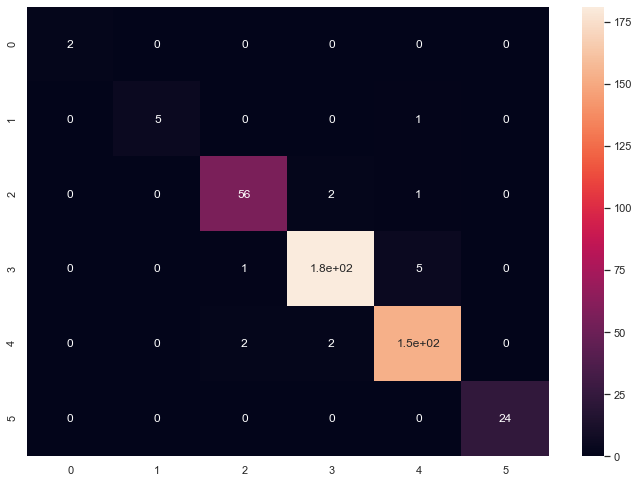

In [ ]:
cm_rating_train = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm_rating_train, annot = True)

In [ ]:
y_pred_test = rating_model.predict(X_test)

<AxesSubplot:>

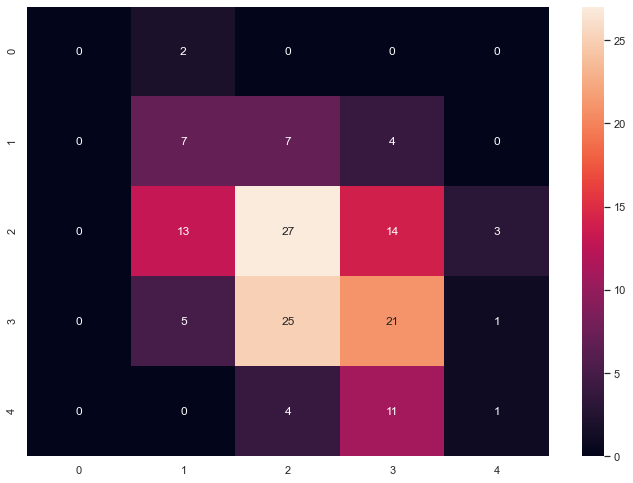

In [ ]:
cm_test = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm_test, annot=True)

In [ ]:
from sklearn import metrics

In [ ]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_test))

Accuracy: 0.38620689655172413


### NLP - Predicting Genre

In [ ]:
genres_label = movie_nlp['movie_genre'].values

In [ ]:
X = movie_countvectorizer_nlp
y = genres_label

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [ ]:
genre_model = NB_classifier.fit(X_train, y_train)

In [ ]:
gen_y_pred_train = genre_model.predict(X_train)

<AxesSubplot:>

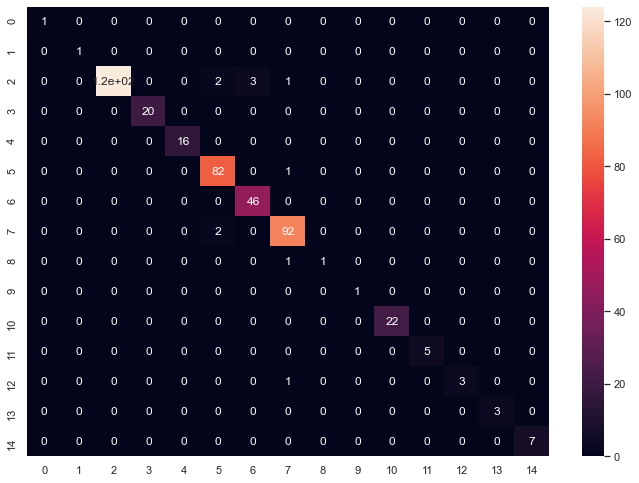

In [ ]:
cm_genre_train = confusion_matrix(y_train, gen_y_pred_train)
sns.heatmap(cm_genre_train, annot = True)

In [ ]:
gen_y_pred_test = genre_model.predict(X_test)

<AxesSubplot:>

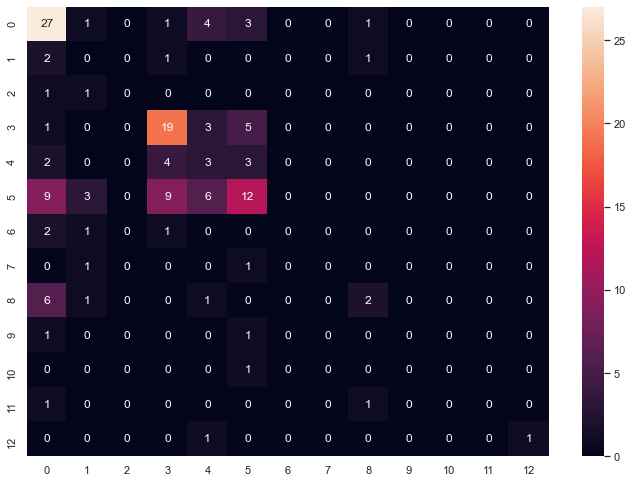

In [ ]:
cm_test_gen = confusion_matrix(y_test, gen_y_pred_test)
sns.heatmap(cm_test_gen, annot=True)

In [ ]:
print("Accuracy:", metrics.accuracy_score(y_test, gen_y_pred_test))

Accuracy: 0.4413793103448276
